In [22]:
import pandas as pd
import pandas_datareader as web
import yfinance as yf
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

In [23]:
dir = '/Users/hynacin/Documents/Kaist/2023-1/FinanceAI/Assignment/Assignment5/data/'

'''
^SPX : S&P500
BMOAX : iShares U.S. Aggregate Bond Index Fund is replication of the Barclays US Aggregate Bond Index
https://www.ishares.com/us/products/227790/blackrock-bond-index-fund-class-a-fund
GSG : iShares S&P GSCI Commodity-Indexed Trust, bechmark index is S&P GSCI(R) Total Return Index
^IRX : 13 Week Treasury Bill, 13 week = 91 day = 3 month
'''

sp500 = web.DataReader('^SPX', 'stooq', '2000-01-01', '2023-05-24')['Close'].sort_index()
bond = pd.read_csv(dir + 'BMOAX.csv', index_col = 0, parse_dates = True)['Adj Close']
commo= pd.read_csv(dir + 'GSG.csv', index_col = 0, parse_dates = True)['Adj Close']
rf= pd.read_csv(dir + '^IRX.csv', index_col = 0, parse_dates = True)['Adj Close'].dropna()/(100 * 252)


In [24]:
rf = pd.DataFrame(rf).dropna()
rf_price = rf.copy()
rf_price.iloc[0,0] = 100

for i in range(len(rf)-1):
    rf_price.iloc[i+1,0] = rf_price.iloc[i,0] * (1 + rf.iloc[i+1, 0])

In [25]:
ass = pd.concat([sp500, bond, commo], axis = 1).dropna()
ret = ass.pct_change()
ass = pd.concat([ass, rf_price], axis = 1).dropna()
ret = pd.concat([ret, rf], axis = 1).dropna()

ass.columns = ['Stock', 'Bond', 'Commodity', 'Cash']
ret.columns = ['Stock', 'Bond', 'Commodity', 'Cash']

asset = ass["2013":"2022-12"]
ret = ret[:"2023-03"]

In [26]:
asset_monthly = asset.copy()
asset_monthly['Date_ym'] = asset_monthly.index.strftime("%Y-%m")
asset_monthly = asset_monthly.groupby('Date_ym').head(1)
asset_monthly = asset_monthly.drop('Date_ym', axis =1)
asset_monthly = asset_monthly.squeeze()


ret_monthly= asset_monthly.pct_change().dropna()

In [27]:
def rebalance(wgt, j):
    wgt1 = wgt
    initial = 1000
    portfolio = pd.DataFrame(columns = ret_monthly.columns, index = ret_monthly.index)
    portfolio['sum'] = 0
    portfolio.iloc[0,-1] = initial
    portfolio.iloc[0,0:-1] = np.array(wgt1.iloc[j,] * initial)

    for i in range(len(portfolio)-1):
        total  = sum(np.array(portfolio.iloc[i,0:-1]) *  np.array(1+ ret_monthly.iloc[i+1,]))
        portfolio.iloc[i+1, -1] = total
        portfolio.iloc[i+1, 0:-1] = np.array(wgt1.iloc[j,] * total)
    portfolio['sum'] = portfolio['sum'].pct_change()
    mean = portfolio['sum'].mean() *12
    std = portfolio['sum'].std() * np.sqrt(12)

    return(mean, std)

In [28]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
        returns = np.sum(mean_returns*weights ) *252
        std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        return std, returns

def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

def portfolio_volatility(weights, mean_returns, cov_matrix):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]


def efficient_return(target):
    num_assets = len(ret.columns)
    args = (ret.mean(), ret.cov())
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, 
                               constraints=constraints)
    return result

def efficient_return_short(target):
    num_assets = len(ret.columns)
    args = (ret.mean(), ret.cov())
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-np.inf,np.inf) for asset in range(num_assets))
    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, 
                               constraints=constraints)
    return result

def efficient_return_const(target):
    num_assets = len(ret.columns)
    args = (ret.mean(), ret.cov())
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,0.4) for asset in range(num_assets))
    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, 
                               constraints=constraints)
    return result


def efficient_return_short_const(target):
    num_assets = len(ret.columns)
    args = (ret.mean(), ret.cov())
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-0.25,0.4) for asset in range(num_assets))
    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, 
                               constraints=constraints)
    return result



def efficient_return(target):
    num_assets = len(ret.columns)
    args = (ret.mean(), ret.cov())
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', tol = 1e-10, bounds=bounds, 
                               constraints=constraints)
    return result    


def efficient_frontier(returns_range):
    efficients = pd.DataFrame()
    i = 0
    for ret in returns_range:
        temp = np.r_[returns_range[i],efficient_return(ret).fun, efficient_return(ret).x]
        efficients = pd.concat([efficients, pd.DataFrame(temp).T])

        i += 1
    efficients.columns = ['ret', 'stds', 'Stock', 'Bond', 'Commodities', 'Cash']
    return efficients

def efficient_frontier_short(returns_range):
    efficients = pd.DataFrame()
    i = 0
    for rets in returns_range:
        temp = np.r_[returns_range[i],efficient_return_short(rets).fun, efficient_return_short(rets).x]
        efficients = pd.concat([efficients, pd.DataFrame(temp).T])

        i += 1
    efficients.columns = ['ret', 'stds', 'Stock', 'Bond', 'Commodities', 'Cash']
    return efficients

def efficient_frontier_const(returns_range):
    efficients = pd.DataFrame()
    i = 0
    for ret in returns_range:
        temp = np.r_[returns_range[i],efficient_return_const(ret).fun, efficient_return_const(ret).x]
        efficients = pd.concat([efficients, pd.DataFrame(temp).T])

        i += 1
    efficients.columns = ['ret', 'stds', 'Stock', 'Bond', 'Commodities', 'Cash']
    return efficients

def efficient_frontier_short_const(returns_range):
    efficients = pd.DataFrame()
    i = 0
    for ret in returns_range:
        temp = np.r_[returns_range[i],efficient_return_short_const(ret).fun, efficient_return_short_const(ret).x]
        efficients = pd.concat([efficients, pd.DataFrame(temp).T])

        i += 1
    efficients.columns = ['ret', 'stds', 'Stock', 'Bond', 'Commodities', 'Cash']
    return efficients



In [29]:
returns_range = np.arange(0.01, 0.3, 0.01)
mean_returns =ret.mean()
cov_matrix = ret.cov()


In [30]:
eff_ftr = efficient_frontier(returns_range)
eff_ftr_short= efficient_frontier_short(returns_range)
eff_ftr_const = efficient_frontier_const(returns_range)
eff_ftr_short_const = efficient_frontier_short_const(returns_range)



/Users/hynacin/opt/anaconda3/envs/my_env/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [72]:
eff_ftr_short.to_csv('short.csv')

In [31]:
eff_ftr = eff_ftr[eff_ftr['Stock']< 0.99]
eff_ftr_short = eff_ftr_short[eff_ftr_short['Stock']< 0.99]
eff_ftr_const = eff_ftr_const[eff_ftr_const['Stock']< 0.39]
eff_ftr_short_const = eff_ftr_short_const[eff_ftr_short_const['Stock']< 0.39]


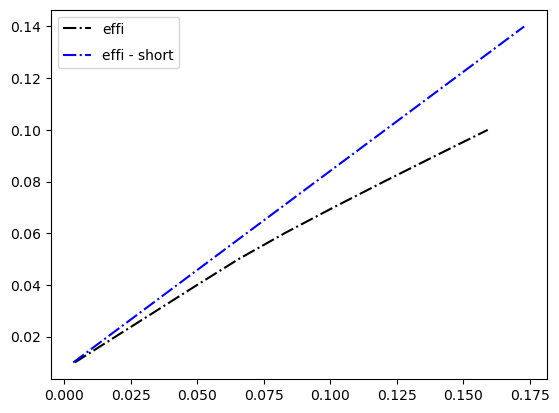

In [76]:
plt.plot(eff_ftr.stds, eff_ftr.ret, linestyle='-.', color='black',                          label='effi')
plt.plot(eff_ftr_short.stds, eff_ftr_short.ret, linestyle='-.', color='blue',               label='effi - short')
#plt.plot(eff_ftr_const.stds, eff_ftr_const.ret, linestyle='-.', color='red',                label='effi - const')
#plt.plot(eff_ftr_short_const.stds, eff_ftr_short_const.ret, linestyle='-.', color='green',  label='effi -short const')

plt.legend(labelspacing = 0.9)

In [33]:
def rebalance(df, j):
    wgt1 = df.iloc[:,2:]
    initial = 1000
    portfolio = pd.DataFrame(columns = ret_monthly.columns, index = ret_monthly.index)
    portfolio['sum'] = 0
    portfolio.iloc[0,-1] = initial
    portfolio.iloc[0,0:-1] = np.array(wgt1.iloc[j,] * initial)

    for i in range(len(portfolio)-1):
        total  = sum(np.array(portfolio.iloc[i,0:-1]) *  np.array(1+ ret_monthly.iloc[i+1,]))
        portfolio.iloc[i+1, -1] = total
        portfolio.iloc[i+1, 0:-1] = np.array(wgt1.iloc[j,] * total)
    portfolio['sum'] = portfolio['sum'].pct_change()
    mean = portfolio['sum'].mean() *12
    std = portfolio['sum'].std() * np.sqrt(12)
    df = pd.DataFrame([std, mean]).T
    return(df)


In [34]:
eff_reb = pd.DataFrame()
eff_reb_short = pd.DataFrame()
eff_reb_const = pd.DataFrame()
eff_reb_short_const = pd.DataFrame()



for j in range(len(eff_ftr)):
    df = rebalance(eff_ftr, j)
    eff_reb = pd.concat([eff_reb, df],axis = 0)
eff_reb = pd.concat([eff_reb, eff_ftr.iloc[:,2:]], axis = 1)

for j in range(len(eff_ftr_short)):
    df = rebalance(eff_ftr_short, j)
    eff_reb_short = pd.concat([eff_reb_short, df],axis = 0)
eff_reb_short = pd.concat([eff_reb_short, eff_ftr_short.iloc[:,2:]], axis = 1)

for j in range(len(eff_ftr_const)):
    df = rebalance(eff_ftr_const, j)
    eff_reb_const = pd.concat([eff_reb_const, df],axis = 0)
eff_reb_const = pd.concat([eff_reb_const, eff_ftr_const.iloc[:,2:]], axis = 1)

for j in range(len(eff_ftr_short_const)):
    df = rebalance(eff_ftr_short_const, j)
    eff_reb_short_const = pd.concat([eff_reb_short_const, df], axis = 0)
eff_reb_short_const = pd.concat([eff_reb_short_const, eff_ftr_short_const.iloc[:,2:]], axis = 1)

eff_reb.columns = ['stds', 'ret', 'Stock', 'Bond', 'Commodities', 'Cash']
eff_reb_short.columns = ['stds', 'ret', 'Stock', 'Bond', 'Commodities', 'Cash']
eff_reb_const.columns = ['stds', 'ret', 'Stock', 'Bond', 'Commodities', 'Cash']
eff_reb_short_const.columns = ['stds', 'ret', 'Stock', 'Bond', 'Commodities', 'Cash']
    

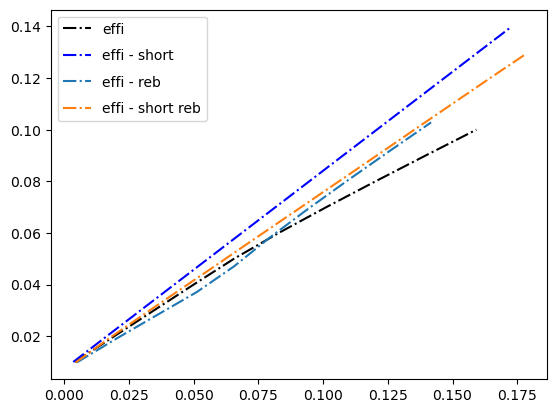

In [75]:
plt.figsize = (30, 20)
plt.plot(eff_ftr.stds, eff_ftr.ret, linestyle='-.', color='black',                         label='effi')
plt.plot(eff_ftr_short.stds, eff_ftr_short.ret, linestyle='-.', color='blue',              label='effi - short')
plt.plot(eff_ftr_const.stds, eff_ftr_const.ret, linestyle='-.', color='red',               label='effi - const')
plt.plot(eff_ftr_short_const.stds, eff_ftr_short_const.ret, linestyle='-.', color='green', label='effi -short const')
plt.plot(eff_reb.stds , eff_reb.ret, linestyle='-.',                                       label='effi - reb')
plt.plot(eff_reb_short.stds , eff_reb_short.ret, linestyle='-.',                           label='effi - short reb')
plt.plot(eff_reb_const.stds , eff_reb_const.ret, linestyle='-.',                           label='effi - const reb')
plt.plot(eff_reb_short_const.stds , eff_reb_short_const.ret, linestyle='-.',               label='effi -short const reb')
plt.legend(labelspacing = 0.9)

In [36]:
def portfolio(df, min, max,i):
    wgt1 = df[(df['ret'] >=  min) & (df['ret'] <=max)].iloc[i,2:]

    initial = 1000
    portfolio = pd.DataFrame(columns = ret_monthly.columns, index = ret_monthly.index)
    portfolio['sum'] = 0
    portfolio.iloc[0,-1] = initial
    portfolio.iloc[0,0:-1] = np.array(wgt1 * initial)
    for i in range(len(portfolio)-1):
        total  = sum(np.array(portfolio.iloc[i,0:-1]) *  np.array(1+ ret_monthly.iloc[i+1,]))
        portfolio.iloc[i+1, -1] = total
        portfolio.iloc[i+1, 0:-1] = np.array(wgt1 * total)


    return portfolio

In [37]:
for i in range(len(eff_ftr[(eff_ftr['ret'] >=  0.07) & (eff_ftr['ret'] <=0.1)])):
    globals()['pfo_1_{}'.format(i+1)] = portfolio(eff_ftr, 0.07, 0.10, i)

for i in range(len(eff_ftr_short[(eff_ftr_short['ret'] >=  0.07) & (eff_ftr_short['ret'] <=0.1)])):
    globals()['pfo_2_{}'.format(i+1)] = portfolio(eff_ftr_short, 0.07, 0.10, i)

for i in range(len(eff_reb[(eff_reb['ret'] >=  0.07) & (eff_reb['ret'] <=0.1)])):
    globals()['pfo_3_{}'.format(i+1)] = portfolio(eff_reb, 0.07, 0.10, i)   
     
for i in range(len(eff_reb_short[(eff_reb_short['ret'] >=  0.07) & (eff_reb_short['ret'] <=0.1)])):
    globals()['pfo_4_{}'.format(i+1)] = portfolio(eff_reb_short, 0.07, 0.10, i)    



In [38]:
num_of_pfo =len(eff_ftr[(eff_ftr['ret'] >=  0.07) & (eff_ftr['ret'] <=0.1)])+len(eff_ftr_short[(eff_ftr_short['ret'] >=  0.07) & (eff_ftr_short['ret'] <=0.1)])+len(eff_reb[(eff_reb['ret'] >=  0.07) & (eff_reb['ret'] <=0.1)])+len(eff_reb_short[(eff_reb_short['ret'] >=  0.07) & (eff_reb_short['ret'] <=0.1)])

In [39]:
def balance_result(df):
        balance = np.array(df['sum'])
        change = [0]
        cum_return = [0]
        prev_high = [0]
        prev_high_tmp = 0
        drawdown = [0]
        mdd = [0]
        mdd_tmp = 0
        CAGR = [0]
        stdev = [0]
        sharpe = [0]
        time_period = (df.index[-1] - df.index[0]).days / 365

        for i in range(1, len(balance)):
            change.append((balance[i] / balance[i-1] - 1) * 100)
            cum_return.append((balance[i] / balance[0] - 1) * 100)

            if prev_high_tmp < cum_return[i]:
                prev_high_tmp = cum_return[i]
            else:
                prev_high_tmp = prev_high_tmp

            prev_high.append(prev_high_tmp)

            drawdown.append(((cum_return[i] + 100) / (prev_high[i] + 100) - 1) * 100)

            if mdd_tmp > drawdown[i]:
                mdd_tmp = drawdown[i]
            else:
                mdd_tmp = mdd_tmp

            mdd.append(mdd_tmp)
            stdev.append(np.std(change))
            CAGR.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)
            if stdev[i] != 0:
                sharpe.append(np.sqrt(252) * np.mean(change) / np.std(change))
            else:
                sharpe.append(0)

        return change, cum_return, prev_high, CAGR, drawdown, mdd


def backtest_result(dt):
        df = pd.DataFrame()
        df['Date'] = dt.index
        df.set_index('Date', inplace=True)
        label = ['Change', 'Cum. Return', 'Prev. High', 'CAGR', 'Drawdown', 'MDD']


        result = dict()

        # 각 자산 i에 대한 밸런스결과 계산
        result['Total'] = balance_result(dt)
        df['Total Balance'] = np.array(dt['sum'])

        # 각 자산별 [Change, ..., Sharpe] 계산
        for j in range(len(label)):
            df[f'Total {label[j]}'] = result['Total'][j]

        backtest_result_df = df
        
        return df



In [41]:
def get_summary(backtest_result_df):
    # columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'STD', 'MDD']
    rf_rate = ret['Cash'].mean() * 252 * 100
    summary = [backtest_result_df['Total Balance'][0], 
                backtest_result_df['Total Balance'][-1],
                str(round(backtest_result_df['Total Change'].std() * np.sqrt(12), 2))+'%',
                str(round(backtest_result_df['Total CAGR'][-1], 2))+'%', 
                str(round(backtest_result_df['Total MDD'][-1], 2))+'%',
                round(backtest_result_df['Total CAGR'][-1]/(backtest_result_df['Total Change'].std() * np.sqrt(12)), 2)]
        
    return summary

def get_summary2(backtest_result_df):
    # columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'STD', 'MDD']
    rf_rate = ret['Cash'].mean() * 252 * 100
    summary = [backtest_result_df['Total Balance'][0], 
                backtest_result_df['Total Balance'][-1],
                str(round(backtest_result_df['Total Change'].std(), 2))+'%',
                str(round(backtest_result_df['Total CAGR'][-1], 2))+'%', 
                str(round(backtest_result_df['Total MDD'][-1], 2))+'%',
                round(backtest_result_df['Total CAGR'][-1]/(backtest_result_df['Total Change'].std()), 2)]
        
    return summary

In [44]:
i,j = 1, 1
ls = []
ind = []
for k in range(num_of_pfo):
        print(i,j)
        
        df= backtest_result(globals()['pfo_{}_{}'.format(i, j)])
        ind.append('pfo_{}_{}'.format(i, j))
        ls.append(get_summary(df))
        
        if i <3:
                if j <4:
                        j +=1
                elif j == 4:
                        i +=1
                        j = 1
        elif i == 3 :
                if j <2:
                        j += 1
                else:
                        i += 1
                        j = 1
        else:
                j += 1
        

1 1
1 2
1 3
1 4
2 1
2 2
2 3
2 4
3 1
3 2
4 1
4 2
4 3


In [64]:
compare = pd.DataFrame(ls, columns =['start', 'end', 'STD', 'CAGR', 'MDD', 'SHARPE'], index = ind).sort_values(by = 'CAGR', ascending = True)

compare


,start,end,STD,CAGR,MDD,SHARPE
pfo_2_1,1000.0,1824.269049,8.35%,6.3%,-24.88%,0.75
pfo_1_1,1000.0,1890.006250,9.39%,6.69%,-18.93%,0.71
pfo_2_2,1000.0,1972.047709,9.69%,7.15%,-28.56%,0.74
pfo_4_1,1000.0,1972.047709,9.69%,7.15%,-28.56%,0.74
pfo_1_2,1000.0,2075.192828,10.93%,7.7%,-20.02%,0.71
pfo_3_1,1000.0,2075.192828,10.93%,7.7%,-20.02%,0.71
pfo_2_3,1000.0,2127.663233,11.02%,7.98%,-32.12%,0.72
pfo_4_2,1000.0,2127.663233,11.02%,7.98%,-32.12%,0.72
pfo_1_3,1000.0,2271.680921,12.51%,8.7%,-21.12%,0.70
pfo_3_2,1000.0,2271.680921,12.51%,8.7%,-21.12%,0.70


In [65]:
compare.to_csv('compare.csv')

In [47]:
def efficient_return_short(target, ret):
    num_assets = len(ret.columns)
    args = (ret.mean(), ret.cov())
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-np.inf,np.inf) for asset in range(num_assets))
    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, 
                               constraints=constraints)
    return result



In [48]:
ret

,Stock,Bond,Commodity,Cash
Date,,,,
2011-04-04,0.000345,0.000990,0.009796,0.000001
2011-04-05,-0.000180,-0.001976,-0.001311,0.000003
2011-04-06,0.002184,-0.001980,0.002363,0.000002
2011-04-07,-0.001520,0.000000,0.007334,0.000001
2011-04-08,-0.004004,-0.000992,0.022881,0.000001
...,...,...,...,...
2023-03-27,0.001647,-0.008743,0.025988,0.000182
2023-03-28,-0.001574,-0.002205,0.004559,0.000184
2023-03-29,0.014237,0.000000,-0.006051,0.000184


In [49]:
ret["2012":"2012"]

,Stock,Bond,Commodity,Cash
Date,,,,
2012-01-03,0.015474,0.000000,0.035779,1.984127e-07
2012-01-04,0.000188,-0.002838,0.004684,3.968254e-07
2012-01-05,0.002944,0.000000,-0.015152,3.968254e-07
2012-01-06,-0.002537,0.001897,0.004438,5.952381e-07
2012-01-09,0.002262,0.000000,0.001178,1.984127e-07
...,...,...,...,...
2012-12-24,-0.002440,-0.000940,-0.003701,1.984127e-06
2012-12-26,-0.004787,0.000000,0.014861,2.182540e-06
2012-12-27,-0.001218,0.001881,-0.000915,2.777778e-06


In [50]:
def wgt(target, i):
    num_assets = len(ret.columns)
    args = (ret["2012":"20{}".format(i)].mean(), ret["2012":"20{}".format(i)].cov())
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, 
                               constraints=constraints)
    return result.x

def wgt_short(target, i):
    num_assets = len(ret.columns)
    args = (ret["2012":"20{}".format(i)].mean(), ret["2012":"20{}".format(i)].cov())
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-np.inf,np.inf) for asset in range(num_assets))
    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, 
                               constraints=constraints)
    return result.x


In [54]:
j = 1
ret_list = [0.07, 0.08, 0.09, 0.1]
for rt in ret_list:
    globals()['wgt_5_{}'.format(j)] = []
    globals()['wgt_6_{}'.format(j)] = []

    for i in range(12, 21):

        
        x = wgt(rt, i)
        y = wgt_short(rt, i)

        globals()['wgt_5_{}'.format(j)].append(x)
        globals()['wgt_6_{}'.format(j)].append(y)
    globals()['wgt_5_{}'.format(j)] = pd.DataFrame(globals()['wgt_5_{}'.format(j)], index = np.arange(2013, 2022), columns = ['Stock', 'Bond', 'Commodities', 'Cash'])
    globals()['wgt_6_{}'.format(j)] = pd.DataFrame(globals()['wgt_6_{}'.format(j)], index = np.arange(2013, 2022), columns = ['Stock', 'Bond', 'Commodities', 'Cash'])
    j+=1



    

In [55]:
asset_yearly = ass['2013':'2022'].copy()
asset_yearly['Date_y'] = asset_yearly.index.strftime("%Y")
asset_yearly = asset_yearly.groupby('Date_y').head(1)
asset_yearly = asset_yearly.drop('Date_y', axis =1)
asset_yearly = asset_yearly.squeeze()

ret_yearly= asset_yearly.pct_change().dropna()

In [58]:
def portfolio_wgt(df):
    wgt1 = df

    initial = 1000
    portfolio = pd.DataFrame(columns = ret_yearly.columns, index = ret_yearly.index)
    portfolio['sum'] = 0
    portfolio.iloc[0,-1] = initial
    portfolio.iloc[0,0:-1] = np.array(wgt1.iloc[0,:] * initial)
    for i in range(len(portfolio)-1):
        total  = sum(np.array(portfolio.iloc[i,0:-1]) *  np.array(1+ ret_yearly.iloc[i+1,]))
        portfolio.iloc[i+1, -1] = total
        portfolio.iloc[i+1, 0:-1] = np.array(wgt1.iloc[i+1, :] * total)


    return portfolio

In [59]:
for j in range(4):
    globals()['pfo_5_{}'.format(j+1)] = portfolio_wgt(globals()['wgt_5_{}'.format(j+1)])
    globals()['pfo_6_{}'.format(j+1)] = portfolio_wgt(globals()['wgt_6_{}'.format(j+1)])




In [60]:
ls2 = []
ind2 = []

for i in range(5,7):
    for j in range(1,5):

        df= backtest_result(globals()['pfo_{}_{}'.format(i, j)])
        ind2.append('pfo_{}_{}'.format(i, j))
        ls2.append(get_summary2(df))

      
compare2 = pd.DataFrame(ls2, columns =['start', 'end', 'STD', 'CAGR', 'MDD', 'SHARPE'], index = ind2).sort_values(by = 'CAGR', ascending = True)


In [61]:
compare2

,start,end,STD,CAGR,MDD,SHARPE
pfo_5_3,1000.0,2265.840396,10.66%,10.75%,-5.41%,1.01
pfo_6_2,1000.0,2331.160098,8.77%,11.15%,-2.02%,1.27
pfo_5_4,1000.0,2438.918529,11.92%,11.78%,-6.16%,0.99
pfo_6_3,1000.0,2575.498586,9.97%,12.54%,-2.55%,1.26
pfo_6_4,1000.0,2841.061962,11.18%,13.93%,-3.11%,1.25
pfo_5_1,1000.0,1946.023571,8.22%,8.67%,-3.92%,1.06
pfo_5_2,1000.0,2101.630383,9.42%,9.72%,-4.67%,1.03
pfo_6_1,1000.0,2104.532354,7.57%,9.74%,-1.48%,1.29


In [62]:
pd.concat([compare, compare2], axis= 0).sort_values(by = 'end')

,start,end,STD,CAGR,MDD,SHARPE
pfo_2_1,1000.0,1824.269049,8.35%,6.3%,-24.88%,0.75
pfo_1_1,1000.0,1890.006250,9.39%,6.69%,-18.93%,0.71
pfo_5_1,1000.0,1946.023571,8.22%,8.67%,-3.92%,1.06
pfo_2_2,1000.0,1972.047709,9.69%,7.15%,-28.56%,0.74
pfo_4_1,1000.0,1972.047709,9.69%,7.15%,-28.56%,0.74
pfo_1_2,1000.0,2075.192828,10.93%,7.7%,-20.02%,0.71
pfo_3_1,1000.0,2075.192828,10.93%,7.7%,-20.02%,0.71
pfo_5_2,1000.0,2101.630383,9.42%,9.72%,-4.67%,1.03
pfo_6_1,1000.0,2104.532354,7.57%,9.74%,-1.48%,1.29
pfo_4_2,1000.0,2127.663233,11.02%,7.98%,-32.12%,0.72
